Notebook putting together concepts from all modeling notebook to construct final model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [173]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [159]:
import sys
sys.path.append('./lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable
#from filename import methodname
#from airbnb_modeling import
#from airbnb_modeling import

In [157]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-31_V3.csv',low_memory=False)
listings = listings.drop(listings.index[4323:4325])
listings.index = [i for i in range(len(listings))]

In [5]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [6]:
cols = [i for i in listings.columns if i not in excluded]
X = listings[cols]

In [7]:
X[X.columns[X.isnull().any()]].isnull().sum()

bathrooms    10
bedrooms      3
beds          4
dtype: int64

In [8]:
X = X.fillna(X.mean())

In [9]:
X = parse_columns(X, ['has_Pets_Allowed',
 'has_Wheelchair_Accessible',
 'has_First_Aid_Kit',
 'has_Cat(s)',
 'has_24-Hour_Check-in',
 'uses_jumio',
'description-Topic0',
 'description-Topic1',
 'description-Topic4',
 'description-Topic5',
 'description-Topic6',
 'description-Topic10',
 'description-Topic11',
 'description-Topic12',
 'description-Topic13',
 'description-Topic15',
 'description-Topic17',
 'description-Topic18',
 'description-Dominant_Topic'])

In [10]:
X_scaled = scale_data(X)
X_normed = normalize_data(X)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [11]:
y_scaled = X_scaled['price_y'].fillna(X_scaled['price_y'].mean())
X_scaled = X_scaled[X_scaled.columns.drop(X_scaled[list(X_scaled.filter(regex='price'))])]

In [12]:
y_normed = X_normed['price_y'].fillna(X_normed['price_y'].mean())
X_normed = X_normed[X_normed.columns.drop(X_normed[list(X_normed.filter(regex='price'))])]

Step1: Simple Model with Linear Regression

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [14]:
print 'Final Number of Features Used: ', len(X_train.columns)

Final Number of Features Used:  147


In [15]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)

In [16]:
lin_reg.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
predictions_train = lin_reg.predict(X_train)

In [18]:
print 'Training R2: ',r2_score(y_train, predictions_train)
print 'Training RMSE: ',np.sqrt(mean_squared_error(y_train, predictions_train))
print 'Training MAE: ',mean_absolute_error(y_train, predictions_train)

Training R2:  0.8370563622789482
Training RMSE:  0.025000294228325958
Training MAE:  0.019394952966789548


In [19]:
tree_reg = DecisionTreeRegressor()

In [20]:
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [21]:
predictions_train = tree_reg.predict(X_train)

In [22]:
print 'Training R2: ',r2_score(y_train, predictions_train)
print 'Training RMSE: ',np.sqrt(mean_squared_error(y_train, predictions_train))
print 'Training MAE: ',mean_absolute_error(y_train, predictions_train)

Training R2:  0.9999977112917995
Training RMSE:  9.36961247430341e-05
Training MAE:  3.9868076865460515e-05


Using Cross Validation

In [23]:
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [24]:
scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [25]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)
print '----'
print '----'
print 'Evaluation Metrics for Tree Regression with CV: '
eval_metrics(scores_tree)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8380051531415182
Validation R2 Mean:  0.814293019382659
Validation R2 STdev:  0.021862904052996634
--
Training RMSE Mean:  0.024925911486976454
Validation RMSE Mean:  0.026554389453347628
Validation RMSE STdev:  6.560971232529337e-05
--
Training MAE Mean:  0.01933250370518464
Validation MAE Mean:  0.020431562030847325
Validation MAE STdev:  0.0009460618498917476
----
----
Evaluation Metrics for Tree Regression with CV: 
Training R2 Mean:  0.9999976743536301
Validation R2 Mean:  0.7298826161183725
Validation R2 STdev:  0.0258700930029843
--
Training RMSE Mean:  9.443382910423506e-05
Validation RMSE Mean:  0.032033824516992104
Validation RMSE STdev:  8.254961206895418e-05
--
Training MAE Mean:  4.036039114372967e-05
Validation MAE Mean:  0.022703490134495647
Validation MAE STdev:  0.0007797635604132367


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn

In [26]:
#plots the RMSE for train and validation as a function of the number of instances in the training set
def plot_rmse_instances(clf, X_train, y_train):

    train_errors, validation_errors = [],[]
    
    n = 2
    
    for i in range(n+1,len(X_train)):
        
        cv_results = cross_validate(clf,X_train[:i],y_train[:i],
                                   scoring='neg_mean_squared_error',
                                   cv=n)
        train_score = np.sqrt(-cv_results['train_score'].mean())
        val_score = np.sqrt(-cv_results['test_score'].mean())
        
        train_errors.append(train_score)
        validation_errors.append(val_score)    
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(validation_errors), "b-", linewidth=2, label='validation')
    plt.xlabel('Number of Instances')
    plt.ylabel('RMSE')
    plt.title('Train and Val RMSE\'s as a Function of Number of Instances')
    plt.show()    

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


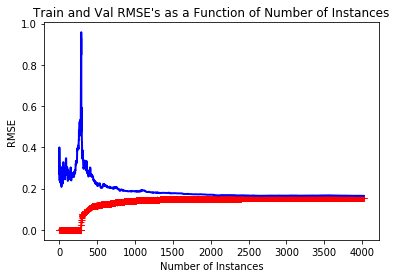

In [27]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
plot_rmse_instances(lin_reg, X_train, y_train)

In [28]:
#Plot the RMSE for training and validation as a function of the number of features used
#ranked features is a list of features sorted by importance - descending
def plot_rmse_features(clf, X_train, y_train, ranked_features):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train[ranked_features], y_train, test_size=0.3)
    
    train_errors, validation_errors = [],[]
    
    for i in range(3,len(ranked_features)):
        clf.fit(X_train.ix[:,2:i],y_train)
        y_train_predict = clf.predict(X_train.ix[:,2:i])
        y_val_predict = clf.predict(X_val.ix[:,2:i])
        train_errors.append(mean_squared_error(y_train_predict, y_train))
        validation_errors.append(mean_squared_error(y_val_predict, y_val))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(validation_errors), "b-", linewidth=2, label='validation')
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.title('Train and Val RMSE\'s as a Function of Number of Features')
    plt.show()    

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


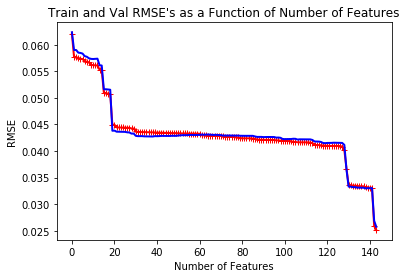

In [29]:
plot_rmse_features(lin_reg, X_normed, y_normed,X_normed.columns)

In [30]:
estimator = linear_model.LinearRegression(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_normed, y_normed)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)

In [31]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 147


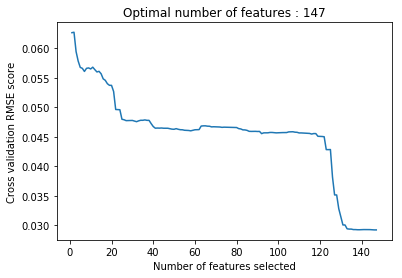

In [32]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

In [33]:
X_new = selector.transform(X_normed)

All features have equally important ranking!

In [34]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Now let's try Linear Regression with CV again and let's see if we have any improvements with the transformed version of X

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_new,y_normed, test_size=0.3, random_state=42)

In [80]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train,y_train)
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8380051531415182
Validation R2 Mean:  0.8142930193826551
Validation R2 STdev:  0.021862904052987547
--
Training RMSE Mean:  0.024925911486976454
Validation RMSE Mean:  0.026554389453347888
Validation RMSE STdev:  6.560971232524848e-05
--
Training MAE Mean:  0.019332503705184766
Validation MAE Mean:  0.02043156203084756
Validation MAE STdev:  0.000946061849890954


The Validation Metrics have all (slightly) improved!

Here we would first rebuild the model only with the important features i.e. number of features where val error is lowest. But in our case, all features are equally important so there is no need to do that. 

In [37]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_normed.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking')
importances.head()

,RFECV_Ranking
description_TextPuncPerc,1
has_Pets_Allowed,1
description-Dominant_Topic,1
event_count_5km,1
host_response_time_enc,1


Let's add interaction features to see if our model will improve. We only select the interaction features that yield an increase in R2 above a certain arbitrary threshold

In [59]:
#X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)
increments = detect_interactions(X_normed,y_normed, 0.01)

In [60]:
X_normed_wint = add_interactions(X_normed, increments)

In [76]:
increments.head()

,Var1,Var2,Increment


In [62]:
X_train_int, X_test_int, y_train, y_test = train_test_split(X_normed_wint,y_normed, test_size=0.3, random_state=42)

In [83]:
lin_reg_int = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg_int.fit(X_train_int, y_train)
scores_lin_int = cross_validate(lin_reg_int, X_train_int, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [84]:
print 'Evaluation Metrics for Linear Regression with CV and Interactions Features: '
eval_metrics(scores_lin_int)

Evaluation Metrics for Linear Regression with CV and Interactions Features: 
Training R2 Mean:  0.8380051531415182
Validation R2 Mean:  0.814293019382659
Validation R2 STdev:  0.021862904052996634
--
Training RMSE Mean:  0.024925911486976454
Validation RMSE Mean:  0.026554389453347628
Validation RMSE STdev:  6.560971232529337e-05
--
Training MAE Mean:  0.01933250370518464
Validation MAE Mean:  0.020431562030847325
Validation MAE STdev:  0.0009460618498917476


Let's pick only interaction features that minimize CV RMSE by feeding the new data into RCEFV

In [65]:
estimator = linear_model.LinearRegression(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train_int, y_train)
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 147


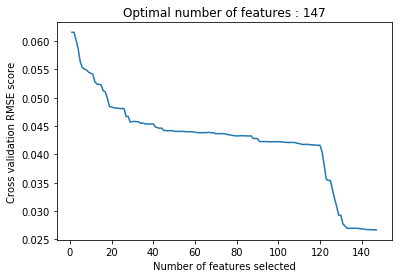

In [66]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

Is it worth adding creating a new model with only important features?

In [47]:
#X_new = selector.transform(X_normed)
#Add rest if needed

In [67]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_int.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking', ascending=False)

In [55]:
best_features = list(importances.head(selector.n_features_).index)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


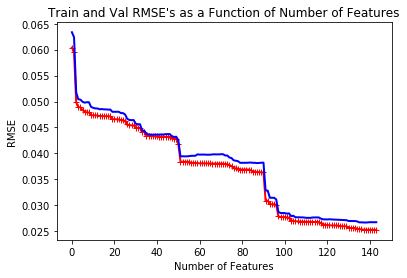

In [70]:
plot_rmse_features(lin_reg_int, X_train_int, y_train,best_features)

Finally, let's see how either of the two models performs against our Test Set

In [81]:
test_predictions = lin_reg.predict(X_test)

In [85]:
test_predictions_int = lin_reg_int.predict(X_test_int)

In [88]:
print 'Evaluation Metrics for LR with no Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Evaluation Metrics for LR with no Interactions
Test R2:  0.8268289492306984
Test RMSE:  0.026044024406866456
Test MAE:  0.019930543353100568


In [89]:
print 'Evaluation Metrics for LR with Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_int)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_int))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_int)

Evaluation Metrics for LR with Interactions
Test R2:  0.8268289492306973
Test RMSE:  0.026044024406866546
Test MAE:  0.019930543353100478


In [160]:
map_variable(y_test-test_predictions, listings)

TypeError: map_variable() takes exactly 1 argument (2 given)

In [ ]:
map_variable(y_test-test_predictions_int, listings)

Plot for LR with no Interactions


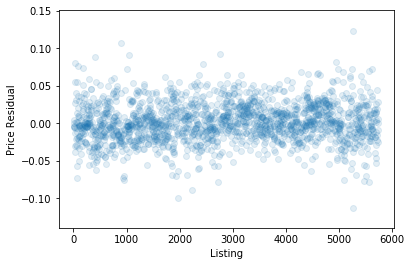

In [90]:
print 'Plot for LR with no Interactions'
plot_residuals(X_test,y_test,test_predictions)

Plot for LR with Interactions


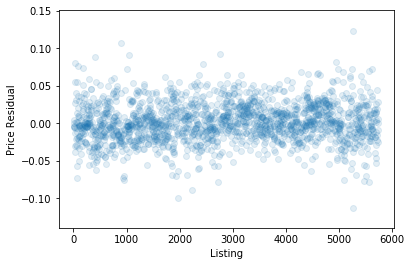

In [91]:
print 'Plot for LR with Interactions'
plot_residuals(X_test,y_test,test_predictions_int)

Plot for LR with no Interactions


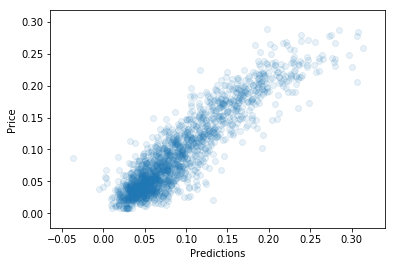

In [92]:
print 'Plot for LR with no Interactions'
plot_predictions(y_test,test_predictions)

Plot for LR with Interactions


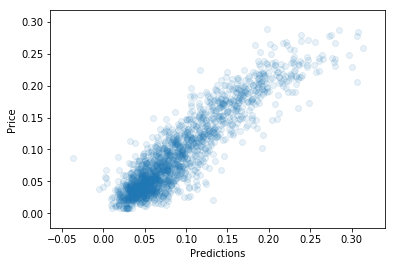

In [93]:
print 'Plot for LR with Interactions'
plot_predictions(y_test,test_predictions_int)

Comment about results with interactions:

Let's introduce some degree of regularization to see if we can decrease validation RMSE even further

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [162]:
lasso = linear_model.Lasso()

In [163]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [164]:
gs = GridSearchCV(lasso, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [165]:
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [166]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

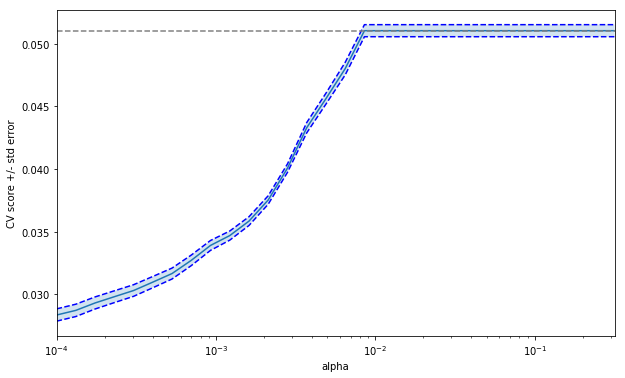

In [167]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [168]:
gs.best_params_

{'alpha': 0.0001}

In [169]:
best_model = gs.best_estimator_

In [170]:
test_predictions = best_model.predict(X_test)

In [171]:
map_variable(y_test-test_predictions, listings)

TypeError: map_variable() takes exactly 1 argument (2 given)

In [ ]:
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Lasso_Coef'})
importances = importances.sort_values(by='Lasso_Coef', ascending=False)

In [106]:
importances[importances['Lasso_Coef']>0]

,Lasso_Coef
availability_90,0.318587
event_count_5km,0.168896
days_since_host,0.147504
event_count_3km,0.147492
calendar_updated_numeric,0.127612
closest_park_full_name_enc,0.087638
availability_365,0.075958
description_TextLength,0.055133
park_count_5km,0.004080


Now trying Ridge:

In [107]:
ridge = linear_model.Ridge()

In [108]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [109]:
gs = GridSearchCV(ridge, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [110]:
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [111]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

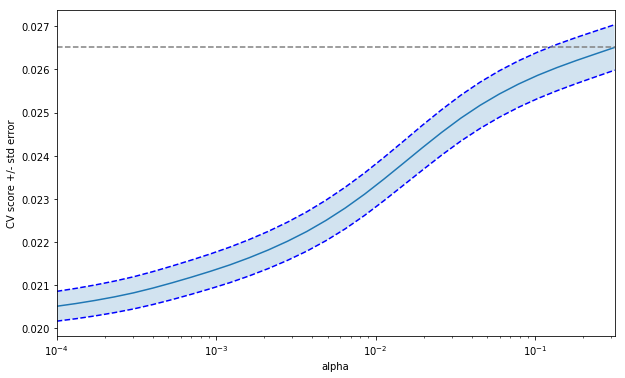

In [112]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [113]:
gs.best_params_

{'alpha': 0.0001}

In [114]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.6882178072731899
Test RMSE:  0.034945889644017694
Test MAE:  0.028166038353961368


In [ ]:
map_variable(y_test-test_predictions, listings)

In [115]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Ridge_Coef'})
importances = importances.sort_values(by='Ridge_Coef', ascending=False)

In [116]:
importances[importances['Ridge_Coef']>0]

,Ridge_Coef
availability_90,0.318587
event_count_5km,0.168896
days_since_host,0.147504
event_count_3km,0.147492
calendar_updated_numeric,0.127612
closest_park_full_name_enc,0.087638
availability_365,0.075958
description_TextLength,0.055133
park_count_5km,0.004080


Now Using ElasticNet

In [117]:
en = linear_model.ElasticNet(random_state=0)

In [118]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [119]:
gs = GridSearchCV(en, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [120]:
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [121]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

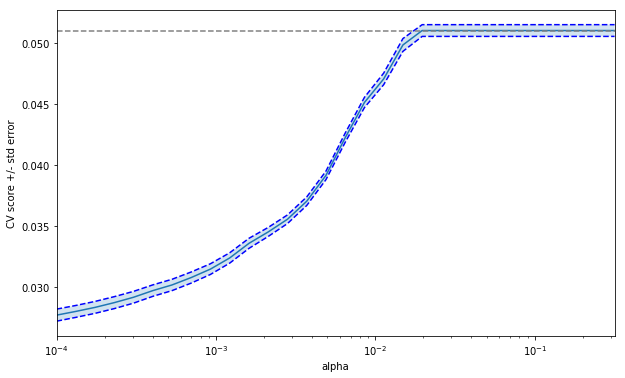

In [122]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [123]:
gs.best_params_

{'alpha': 0.0001}

In [124]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.6882178072731899
Test RMSE:  0.034945889644017694
Test MAE:  0.028166038353961368


In [ ]:
map_variable(y_test-test_predictions, listings)

In [125]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'EN_Coef'})
importances = importances.sort_values(by='EN_Coef', ascending=False)

In [126]:
importances[importances['EN_Coef']>0]

,EN_Coef
availability_90,0.318587
event_count_5km,0.168896
days_since_host,0.147504
event_count_3km,0.147492
calendar_updated_numeric,0.127612
closest_park_full_name_enc,0.087638
availability_365,0.075958
description_TextLength,0.055133
park_count_5km,0.004080


Ensembles

RandomForest Regression

The Random Forest Regressor Does very well on both Training and Validation - a promising model!

In [127]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8,10,12]},
    {'bootstrap': [True,False], 'n_estimators':[3,10], 'max_features':[2,4,6,8,10,12]},
]

In [128]:
new_for_reg = RandomForestRegressor()

In [129]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')

In [130]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10, 12]}, {'n_estimators': [3, 10], 'max_features': [2, 4, 6, 8, 10, 12], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [131]:
gs.best_params_

{'bootstrap': False, 'max_features': 12, 'n_estimators': 10}

In [133]:
gs_results = gs.cv_results_

In [134]:
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

Avg Mean Train Score:  0.00766476515654314
Avg Mean Val Score:  0.025727713998527368


In [135]:
imp = gs.best_estimator_.feature_importances_

In [139]:
from operator import itemgetter
imp = pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance'])

In [142]:
imp.sort_values(by='Importance', ascending=False).head()

,Feature,Importance
0,accommodates,0.120586
1,uses_amex,0.113655
2,bathrooms,0.091961
3,bedrooms,0.076834
4,has_Pets_Allowed,0.058362


Now testing with Test Dataset:

In [145]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.8015733441870713
Test RMSE:  0.027878567481147618
Test MAE:  0.01997817412572725


In [ ]:
map_variable(y_test-test_predictions, listings)

Now trying SVR

In [146]:
sv_reg = SVR()

In [147]:
param_grid = [
    {'C':[i for i in range(1,20,2)], 'epsilon':[i for i in range(1,18,1)], 'kernel':['linear', 'poly', 'rbf'],
    'degree':[2,3,4]},]

In [153]:
gs = GridSearchCV(sv_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [154]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'degree': [2, 3, 4], 'kernel': ['linear', 'poly', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
gs_results = gs.cv_results_
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

In [ ]:
gs.best_params_

In [ ]:
from operator import itemgetter
imp = pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance'])
imp.sort_values(by='Importance', ascending=False).head()

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
plot_predictions(y_test,test_predictions)

SVR did not give satisfactory results

Bagging Regressor

In [174]:
br = BaggingRegressor()

In [186]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[i for i in range(10,80,10)], 'bootstrap': [True,False]},
]

In [187]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [10, 20, 30, 40, 50, 60, 70], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [180]:
print gs.best_params_
print gs.best_estimator_
gs_results = gs.cv_results_

{'max_features': 60, 'n_estimators': 30, 'bootstrap': False}
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=60, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [181]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [188]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.880119538667515
Test RMSE:  0.02166928843241862
Test MAE:  0.015614711591900168


In [189]:
map_variable(y_test-test_predictions, listings)

TypeError: map_variable() takes exactly 1 argument (2 given)

In [ ]:
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
plot_predictions(y_test,test_predictions)

Now doing nonlinear regressions with Interaction Features

In [ ]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 2)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 3)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)